In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import random
import json

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'keras.layers.merge'

In [4]:
DATASET_RAW = "../datasets/flickr/raw"
DATASET_INTERIM = "../datasets/flickr/interim"
CHECKPOINTS = "../checkpoints/flickr"
OUTPUTS = "../outputs/baseline"


## Load & clean captions

In [5]:
def clean_caption(caption, table):
    caption.replace("-", " ")    # Replace "-" with " "
    words = caption.split()      # Split the words

    words = [word.lower() for word in words]    # Convert to lowercase
    words = [word.translate(table) for word in words]  # Remove punctuations
    words = [word for word in words if(len(word)>1)]   # Remove 's and a
    words = [word for word in words if(word.isalpha())] # Remove tokens with numbers

    return f"<start>{' '.join(words)}<end>"


def load_captions(filename):
    # Load the text file into memory
    file = open(filename, 'r')
    text = file.read()
    file.close()
    table = str.maketrans('', '', string.punctuation)

    img_captions = dict()

    lines = text.split('\n')
    for line in lines[1:]:
        if len(line) == 0:
            continue
        img, caption = line.split(',', 1)
        # Clean the caption text
        caption = clean_caption(caption, table)
        if img in img_captions:
            img_captions[img].append(caption)
        else:
            img_captions[img] = [caption]

    return img_captions


img_captions = load_captions(os.path.join(DATASET_RAW, 'captions.txt'))
print(f"Number of captions: \t{len(img_captions)}")


Number of captions: 	8091


In [4]:
# # Save the cleaned captions to interim dir
# with open(os.path.join(DATASET_INTERIM, 'captions.json'), 'w') as file:
#     json.dump(img_captions, file)


In [5]:
with open(os.path.join(DATASET_INTERIM, 'captions.json'), 'rb') as file:
    img_captions = json.load(file)


## Extracting the features from images 

In [6]:
def extract_img_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features

# img_features = extract_img_features(os.path.join(DATASET_RAW, 'Images'))

# # Save the extracted image features to interim dir
# dump(img_features, open(os.path.join(DATASET_INTERIM, 'img_features.pkl'), 'wb'))


In [7]:
img_features = load(open(os.path.join(DATASET_INTERIM, 'img_features.pkl'),"rb"))

print(f"# of images: {len(img_features)}")
print(f"Dimension of an image feature {img_features[list(img_features.keys())[0]].shape}")


# of images: 8091
Dimension of an image feature (1, 2048)


## Split the training/dev/test set

In [8]:
img_files = list(img_captions.keys())

assert len(img_files) > 7000, "The list must have more than 7000 elements."

# Shuffle the list in place
random.shuffle(img_files)

# Split into training, dev, and test datasets
train_imgs = img_files[:6000]
dev_imgs = img_files[6000:7000]
test_imgs = img_files[7000:]  # The remaining part of the list

dataset = {
    "train": train_imgs,
    "dev": dev_imgs,
    "test": test_imgs
}

print(f"train: {len(train_imgs)} | dev: {len(dev_imgs)} | test: {len(test_imgs)}")


train: 6000 | dev: 1000 | test: 1091


In [9]:
# # Save the dataset keys into interim dir
# with open(os.path.join(DATASET_INTERIM, 'dataset_keys.json'), 'w') as file:
#     json.dump(dataset, file)


In [10]:
def get_captions(img_captions, mode, dataset):
    """
    Generate an img-captions dictionary with images in a specific dataset

    Return:
        A dictionary (img filename: <start> caption <end>
    """
    captions = dict()
    for img_name in img_captions:
        if img_name in dataset[mode]:
            captions[img_name] = img_captions[img_name]

    return captions


def get_img_features(img_features, mode, dataset):
    """
    Get the extracted features for images in a specific dataset

    Return:
        A dictionary (img filename: <start> caption <end>
    """
    features = dict()
    for img_name in img_features:
        if img_name in dataset[mode]:
            features[img_name] = img_features[img_name]

    return features


In [11]:
all_captions = img_captions
all_img_features = img_features

train_captions = get_captions(img_captions, "train", dataset)
train_img_features = get_img_features(img_features, "train", dataset)

dev_captions = get_captions(img_captions, "dev", dataset)
dev_img_features = get_img_features(img_features, "dev", dataset)

test_captions = get_captions(img_captions, "test", dataset)
test_img_features = get_img_features(img_features, "test", dataset)


In [12]:
print(len(all_captions), len(train_captions), len(dev_captions), len(test_captions))
print(len(all_img_features), len(train_img_features), len(dev_img_features), len(test_img_features))


8091 6000 1000 1091
8091 6000 1000 1091


## Create tokenizer from the captions in the training set

In [13]:
def dict_to_list(captions):
    all_caption = []
    for key in captions:
        [all_caption.append(caption) for caption in captions[key]]
    return all_caption


def create_tokenizer(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(dict_to_list(captions))
    return tokenizer


tokenizer = create_tokenizer(train_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Size of vocab = {vocab_size}")


Size of vocab = 7649


In [14]:
# # Save the tokenize to hard drive
# dump(tokenizer, open(os.path.join(DATASET_INTERIM, 'tokenizer.pkl'), 'wb'))


In [15]:
def max_length(captions):
    desc_list = dict_to_list(captions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(img_captions)
max_length


32

## Model & Data Generator

In [16]:
# create input-output sequence pairs from the image description.

# data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length=32):
    while True:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word


def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# You can check the shape of the input and output for your model
[a, b], c = next(data_generator(train_captions, train_img_features, tokenizer, max_length))
a.shape, b.shape, c.shape


((47, 2048), (47, 32), (47, 7649))

In [17]:
# from keras.utils import plot_model
import tensorflow as tf

def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    # print(model.summary())
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [18]:
model = define_model(vocab_size, max_length)


2023-11-07 22:17:44.209920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 22:17:44.227967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 22:17:44.228856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 22:17:44.230644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train =', len(train_captions))
print('Photos: train =', len(train_img_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# model = define_model(vocab_size, max_length)
# epochs = 10
# steps = len(train_captions)
# # making a directory models to save our models
# for i in range(epochs):
#     generator = data_generator(train_captions, train_img_features, tokenizer, max_length)
#     model.fit(x=generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save(os.path.join(CHECKPOINTS, f"/model_{str(i)}.h5"))


Dataset:  6000
Descriptions: train = 6000
Photos: train = 6000
Vocabulary Size: 7649
Description Length:  32


## Test the model

In [177]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


class CaptionGenerator:
    def __init__(self, caption_gen_model, feature_extraction_model, tokenizer, dataset_keys, max_length=32, extracted_features=None):
        self.caption_gen_model = caption_gen_model
        self.feature_extraction_model = feature_extraction_model
        self.tokenizer = tokenizer
        self.datasets = dataset_keys
        self.max_length = max_length
        self.extracted_features = extracted_features

    def extract_img_features(self, filename):
        try:
            image = Image.open(filename)
        except Exception as e:
            print(e)
            print(f"ERROR: Couldn't open image at {filename}")
            return
        image = image.resize((299, 299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = self.feature_extraction_model.predict(image)
        return feature

    def generate_caption(self, img_idx):
        if img_idx >= len(self.datasets):
            print(f"Couldn't find {img_idx} in the dataset")
            return

        img_path = os.path.join(DATASET_RAW, 'Images', self.datasets[img_idx])

        if self.extracted_features is None or img_idx not in self.extracted_features:
            img_feature = self.extract_img_features(img_path)
        else:
            img_feature = self.extracted_features[self.datasets[img_idx]]

        in_text = 'start'
        caption = []
        for _ in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            # Infer the next word
            pred = self.caption_gen_model.predict([img_feature, sequence], verbose=0)
            pred = np.argmax(pred)
            # Get the word from the tokenizer
            word = self.word_for_id(pred)
            if word is None:
                break
            caption.append(word)
            in_text += ' ' + word
            if word == 'end':
                break
        generated_caption = ' '.join(caption[:-1])

        return generated_caption, img_path

    def generate_caption_and_show(self, img_idx):
        generated_caption, img_path = self.generate_caption(img_idx)
        print(generated_caption)
        img = Image.open(img_path)
        plt.imshow(img)

    def word_for_id(self, integer):
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None


In [103]:
# Load the image and generate the caption
dataset_keys = json.load(
    open(os.path.join(DATASET_INTERIM, "dataset_keys.json"), "rb")
)

# Load the model and tokenizer
max_length = 32
tokenizer = load(
    open(os.path.join(DATASET_INTERIM, "tokenizer.pkl"), "rb")
)
model = load_model(os.path.join(CHECKPOINTS, 'baseline_9.h5'))
xception_model = Xception(include_top=False, pooling="avg")


In [ ]:
dataset_keys['test']


In [180]:
test_generator = CaptionGenerator(model, xception_model, tokenizer, dataset_keys['test'], 32, all_img_features)


In [186]:
dataset_keys['test'][3]


'2502354602_f4d6dcf42d.jpg'

In [185]:
'369047365_35476becc9.jpg' in dataset_keys['test']


False

3477715432_79d82487bb.jpg
one girl wearing pajamas stands near to girl who is holding flyer
two girls are playing with sparklers


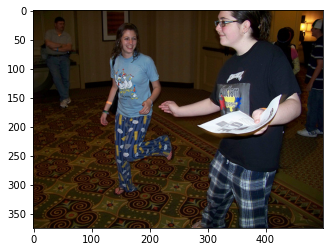

In [201]:
img_idx = 770

img_filename = dataset_keys['test'][img_idx]

print(img_filename)
gt = all_captions[img_filename][0][7:-5]
print(gt)
test_generator.generate_caption_and_show(img_idx)


In [173]:
img_filename


'3029715635_43ab414dfb.jpg'

In [134]:
import time


def generate_caption_for_all_dataset(dataset):
    # Load the image and generate the caption
    dataset_keys = json.load(
        open(os.path.join(DATASET_INTERIM, "dataset_keys.json"), "rb")
    )

    # Load the model and tokenizer
    max_length = 32
    tokenizer = load(
        open(os.path.join(DATASET_INTERIM, "tokenizer.pkl"), "rb")
    )
    model = load_model(os.path.join(CHECKPOINTS, 'baseline_9.h5'))
    xception_model = Xception(include_top=False, pooling="avg")

    generator = CaptionGenerator(model, xception_model, tokenizer, dataset)

    results = {}
    infer_times = []
    for img_idx in range(0, len(dataset), 20):
        start_time = time.time()
        enerated_caption, img_path = generator.generate_caption(img_idx)
        results[dataset[img_idx]] = enerated_caption
        end_time = time.time()
        infer_time = end_time - start_time
        infer_times.append(infer_time)

        print(f"{img_idx}: \t{enerated_caption}")

    average_infer_time = sum(infer_times) / len(infer_times)
    print(f"Average time for each inference: {average_infer_time:.2f} seconds")

    return results


In [135]:
candidate_captions = generate_caption_for_all_dataset(dataset_keys['test'])


0: 	man in black shirt and hat is riding unicycle on street
20: 	man in red shorts is sitting on the edge of the water
40: 	man in black shirt and black boots is walking down the street
60: 	little girl in pink shirt is playing with water
80: 	man in white shirt is playing tennis
100: 	man in black shirt and black and white top is walking down the street
120: 	man in black shirt is jumping on his skateboard
140: 	man is climbing up rock
160: 	man in red shirt is standing in front of an ambulance
180: 	man in blue shirt is riding dirt bike
200: 	man in black shirt is standing on the sidewalk with his arms outstretched
220: 	man in black shirt is walking on the street
240: 	man in black shirt is standing in front of the photographer
260: 	black dog is running through the grass
280: 	man in black shirt is standing on the grass with his arms outstretched
300: 	man in black shirt is standing in front of the camera
320: 	girl in pink shirt is sitting on the grass
340: 	man in red and blue ri

In [139]:
with open(os.path.join(OUTPUTS, 'test_results.json'), 'w') as file:
    json.dump(candidate_captions, file)


In [165]:
with open(os.path.join(OUTPUTS, 'test_results.json'), 'rb') as file:
    candidate_captions = json.load(file)

reference_captions = {}
for filename in candidate_captions:
    reference_captions[filename] = all_captions[filename][0][7:-5]

len(reference_captions) == len(candidate_captions)


True

In [168]:
def measure_BLEU_METEOR(candidate_captions, reference_captions):
    # NLTK BLEU Score
    print("NLTK BLEU Score:")
    scores = []
    for key in candidate_captions.keys():
        # Note: the reference list of lists is expected here where each reference should be tokenized into words.
        print(candidate_captions[key])
        print(reference_captions[key])
        print()
        candidate_tokens = candidate_captions[key].split()
        reference_tokens = [reference_captions[key].split()]
        score = sentence_bleu(reference_tokens, candidate_tokens)
        # print(reference_tokens)
        # print(candidate_tokens)
        scores.append(score)

    average_score = sum(scores) / len(candidate_captions)
    print(f"Average BLEU score: {average_score:.4f}")


    # NLTK METEOR Score
    print("\nNLTK METEOR Score:")
    scores = []
    for key in candidate_captions.keys():
        # Note: the reference list of lists is expected here where each reference should be tokenized into words.
        candidate_tokens = candidate_captions[key].split()
        reference_tokens = [reference_captions[key].split()]
        score = meteor_score(reference_tokens, candidate_tokens)
        # print(reference_tokens)
        # print(candidate_tokens)
        scores.append(score)

    average_score = sum(scores) / len(candidate_captions)
    print(f"Average BLEU score: {average_score:.4f}")

measure_BLEU_METEOR(candidate_captions, reference_captions)


NLTK BLEU Score:
man in black shirt and hat is riding unicycle on street
group of bohemians stroll down the street one with shopping cart

man in red shorts is sitting on the edge of the water
one man in the hole of tire in water and another man getting up from the water next to him

man in black shirt and black boots is walking down the street
girl in green walks down city street

little girl in pink shirt is playing with water
small girl wearing pink top and jeans stands on field with others in the background

man in white shirt is playing tennis
girl in black shirt and hot pink pants is about to hit tennis ball on the court

man in black shirt and black and white top is walking down the street
man is talking on cellphone outside of bar

man in black shirt is jumping on his skateboard
boy is outside jumping over flower bush on skateboard

man is climbing up rock
man climbing cliff face

man in red shirt is standing in front of an ambulance
man riding motorcycle down the sidewalk

man

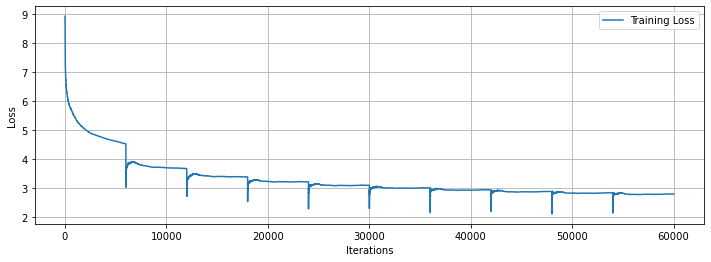

In [204]:
import matplotlib.pyplot as plt
import re
import os

loss_values = []

with open(
    os.path.join(OUTPUTS, 'train.log'), 'r'
) as file:
    for line in file:
        # Use regex to find patterns of loss values in the log
        match = re.search(r'loss: ([0-9]+\.[0-9]+)', line)
        if match:
            # If a loss value is found, convert it to float and append it to the list
            loss_values.append(float(match.group(1)))


# Plot the loss values
plt.figure(figsize=(12, 4))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# plt.title('Change of Loss During Training')
plt.grid()
plt.legend()
plt.savefig(os.path.join(OUTPUTS, 'img', 'loss.png'))
plt.show()
